In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [ ]:
# Загрузка данных
file_path = "/content/drive/MyDrive/DF-ChurnPrediction/data/train_ai_comp_final_dp.parquet"
data = pd.read_parquet(file_path, engine="pyarrow")

In [ ]:
data.head()

,id,target,sample_ml_new,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature1067,feature1068,feature1069,feature1070,feature1071,feature1072,feature1073,feature1074,feature1075,feature1076
0,0,0,1,1761,1759,85,105469,191,46,0,...,28913,48985,84264,12045,12107,12510,21126,28913,48985,84264
1,1,0,1,1761,1759,120,105610,144,71,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,1,890,1759,141,105227,191,11,0,...,55949,70006,113317,33735,31242,12691,48682,55949,70006,113317
5,5,0,1,1599,966,30,102441,191,8,0,...,0,6872,8530,0,0,0,0,0,6872,8530
6,6,0,1,1761,1759,85,104006,191,2,0,...,0,0,7642,0,0,0,0,0,0,7642


In [ ]:
data.shape

(519615, 1079)

In [ ]:
# Подсчет процента пропущенных значений в каждом столбце
missing_values = (data.isnull().sum() / len(data)) * 100

In [ ]:
missing_values.sort_values(ascending=False)

feature756     100.00000
feature642      60.68416
feature715       0.00000
feature721       0.00000
feature720       0.00000
                 ...    
feature363       0.00000
feature364       0.00000
feature365       0.00000
feature366       0.00000
feature1076      0.00000
Length: 1079, dtype: float64

Видим, что в колонке feature756 только пропущенные значения, она нам будет не нужна для подсчета. Проанализируем колонку feature642

In [ ]:
data['feature642'].value_counts(1)

0.0    0.980577
1.0    0.019423
Name: feature642, dtype: float64

Колонка feature642 категориальная, с большим перевесом ко значению 0. Посмотрим, отличается ли процент распределения у клиентов с target 0 и target 1.

In [ ]:
cross_tab = pd.crosstab(data['feature642'], data['target'], normalize='index')
cross_tab

target,0,1
feature642,,
0.0,0.971241,0.028759
1.0,0.980595,0.019405


In [ ]:
data[['target', 'feature642']].corr().iloc[0, 1]

-0.007747397296001008

Видим, что распределения не изменяется и коэффициент корреляции практически равен 0. Учитывая все совокупности факторов (большой процент пропусков, малое значения коэфициента корреляции), можно сделать вывод, что данную колонку также можно удалить

In [ ]:
data = data.drop(['sample_ml_new', 'feature756', 'feature642'], axis=1)

In [ ]:
single_value_columns = data.columns[data.nunique() == 1]
len(single_value_columns)

88

В датасете есть 88 колонок, в которых только одно уникальное значение. Они не несут никакой информативной ценности. Их тоже следует удалить

In [ ]:
data = data.drop(single_value_columns, axis=1)

Оценим распределение целевой переменной target

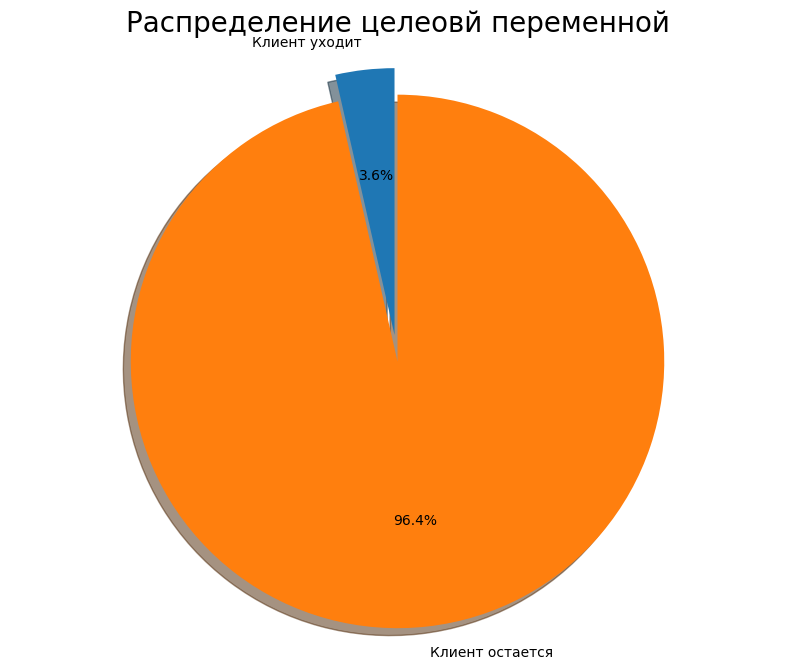

In [ ]:
labels = 'Клиент уходит', 'Клиент остается'
sizes = [data.target[data['target']==1].count(), data.target[data['target']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Распределение целеовй переменной", size = 20)
plt.show()

In [ ]:
# DataFrame с процентным соотношением самого часто встречающегося значения
percentage_df = pd.DataFrame({
    'top_value_percentage': data.apply(lambda col: col.value_counts(normalize=True).max() * 100)
})

sorted_percentage_df = percentage_df.sort_values(by='top_value_percentage', ascending=False)
sorted_percentage_df

,top_value_percentage
feature711,99.999615
feature700,99.999615
feature662,99.999615
feature886,99.999615
feature26,99.999423
...,...
feature226,0.016743
feature191,0.015396
feature190,0.015396
feature189,0.015396


Есть предположение, что колонки с большим процентом самого популярного значения (возьмем значение 96%) не несут никакой ценности для целевой переменной. Посчитаем коэффициент корреляции для этих колонок и выведем в порядке убывания

In [ ]:
more_96_persentage = sorted_percentage_df[sorted_percentage_df['top_value_percentage'] > 96]

In [ ]:
more_96_persentage

,top_value_percentage
feature711,99.999615
feature700,99.999615
feature662,99.999615
feature886,99.999615
feature26,99.999423
...,...
feature743,96.030907
feature639,96.030907
feature849,96.030907
feature851,96.030907


In [ ]:
correlation_cols = more_96_persentage.index.tolist()

correlation_matrix = data[correlation_cols].corr()

In [ ]:
selected_columns = correlation_matrix['target'][abs(correlation_matrix['target']) < 0.2].index.tolist()

Уберем колонки, у которых коэффициент корреляции меньше 2 и процент самого популярного элемента больше 96

In [ ]:
data = data.drop(selected_columns, axis=1)

Сохраним оставшиеся колонки в новый файл для дальейшей работы

In [ ]:
data.to_parquet('new_selected_data.parquet', engine='pyarrow')